In [42]:
import tensorflow as tf
import tensorflow_datasets as tfds
from bs4 import BeautifulSoup ## for removing html tags
from tensorflow.keras.preprocessing.text import Tokenizer ## For tokenization
import string
import csv
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [44]:
# Stop Words
stopwords = ['a','the', 'and', 'of', 'to', 'is', 'in', 'it', 'this', 'i', 'that', 'was', 'as', 'with', 'for', 'movie', 'but', 'film', 'on', 'not', 'are', 'you', 'his', 'have', 'be', 'he', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'who', 'from', 'like', 'so', 'her', 'or', 'just', 'about', 'has', 'out', 'if', 'some', 'what']


In [46]:
## Tokenizing the dataset as per the last chapter
sentences=[]
labels=[]
table = str.maketrans('', '', string.punctuation)
with open('sentiment_analysis.csv', newline="", encoding="utf-8") as csvfile:
     reader = csv.reader(csvfile, delimiter=",")
     next(reader) # Skip header file
     for row in reader:
         # 0 id, 1 label, 2 tweet
         labels.append(int(row[1]))
         sentence = row[2].lower()
         sentence = sentence.replace(",", " , ")
         sentence = sentence.replace(".", " . ")
         sentence = sentence.replace("-", " - ")
         sentence = sentence.replace("/", " / ")
         soup = BeautifulSoup(sentence)
         sentence = soup.get_text()
         words = sentence.split()
         filtered_sentence = ""
         for word in words:
             word = word.translate(table)
             if word not in stopwords:
                 filtered_sentence = filtered_sentence + word + " "
         sentences.append(filtered_sentence)


training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

training_labels = np.array(training_labels, dtype=np.int32)
testing_labels = np.array(testing_labels, dtype=np.int32)

vocab_size = 20455
max_length = 10
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) # Define tokenizer
tokenizer.fit_on_texts(training_sentences) # Fit
word_index = tokenizer.word_index

# Tokenize and then pad sentences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
## For validation
test_sequences = tokenizer.texts_to_sequences(testing_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

C:\Users\Yusuf Solomon\AppData\Local\Temp\ipykernel_14884\1290670868.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [64]:
## Embeddings in NLP are basically vector reprsentations of words, that capture their meanings in relationship with other words
## This way, Neural networks can associates things like sentiment, or meaning through the similarity between words more asocciaated with particular
## Sentiments or meanings
## The vector representation of similar words would then be automatically closer to each other
## Embeddings greatly improve the performance of neural networks in NLP

# Defining a model that utilizes embeddings witha n embedding layer that learns the embeddings of words
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7652 - loss: 0.5104 - val_accuracy: 0.8580 - val_loss: 0.3396
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8980 - loss: 0.2672 - val_accuracy: 0.8845 - val_loss: 0.2730
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9339 - loss: 0.1824 - val_accuracy: 0.8845 - val_loss: 0.2677
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9566 - loss: 0.1292 - val_accuracy: 0.8782 - val_loss: 0.2786
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9725 - loss: 0.0923 - val_accuracy: 0.8750 - val_loss: 0.3005
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9820 - loss: 0.0659 - val_accuracy: 0.8712 - val_loss: 0.3297
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9883 - loss: 0.0478 - val_accuracy: 0.8655 - val_loss: 0.3606
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9923 - loss: 0.0353 - val_accuracy: 0.

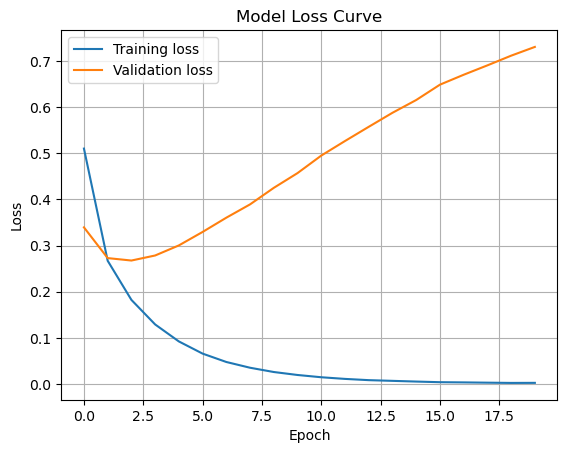

In [62]:
## Plotting the loss curve
history = model.fit(
    training_padded, training_labels,
    validation_data=(test_padded, testing_labels),
    epochs=20,
    batch_size=32
)

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

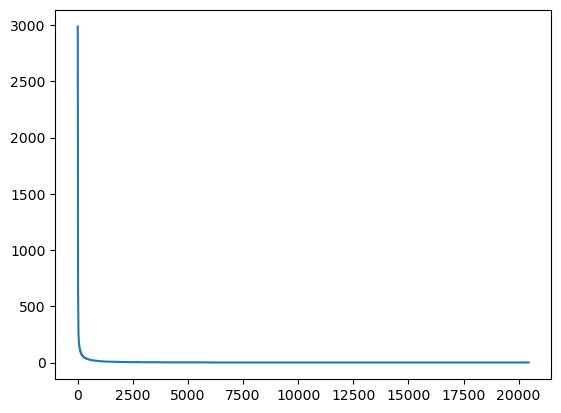

In [66]:
## Wow the model is horrible, it overfits so bad, there are three ways to reduce overfitting in NLP models as highlighted in the book
# 1. Reducing the learninf rate of the optimizer, adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# 2. Reduce the vocab_size, based on frequency of the words
from collections import OrderedDict
wc=tokenizer.word_counts
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
## We would investigate the true frequency of words in our dataset to pick a suitable vocab size for our embedding layer

xs=[]
ys=[]
curr_x = 1
for item in newlist:
    xs.append(curr_x)
    curr_x=curr_x+1
    ys.append(newlist[item])
plt.plot(xs,ys)
plt.show()

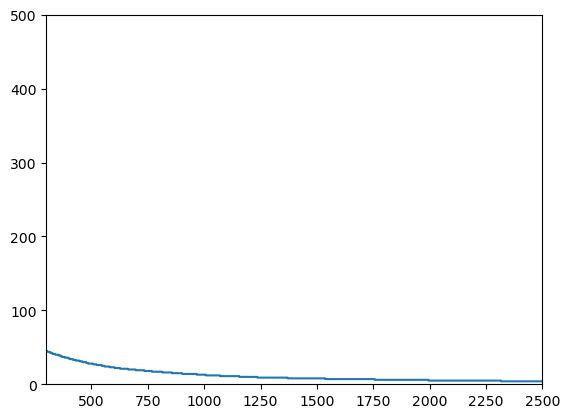

In [70]:
## We have to properly inspect the graph 
plt.plot(xs,ys)
plt.axis([300,2500,0,500])
plt.show()

In [72]:
## Wow, so we need our vocab size to be a lot less than it is already, i would use 750
# Now we would re tokenize the data

vocab_size = 750 # Change the vocab size
max_length = 10
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) # Define tokenizer
tokenizer.fit_on_texts(training_sentences) # Fit
word_index = tokenizer.word_index

# Tokenize and then pad sentences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
## For validation
test_sequences = tokenizer.texts_to_sequences(testing_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [74]:
## 3. Use of regularization in the model, most NLP models use l2
# It woul also help to remove the number of neurons due to our small vocab size, i will use just 16, then 8


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
 ])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer= adam , metrics=['accuracy'])


Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7405 - loss: 0.8998 - val_accuracy: 0.7519 - val_loss: 0.8547
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7423 - loss: 0.8202 - val_accuracy: 0.7519 - val_loss: 0.7814
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7423 - loss: 0.7602 - val_accuracy: 0.7519 - val_loss: 0.7312
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7423 - loss: 0.7204 - val_accuracy: 0.7519 - val_loss: 0.6978
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7423 - loss: 0.6907 - val_accuracy: 0.7519 - val_loss: 0.6701
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7423 - loss: 0.6634 - val_accuracy: 0.7519 - val_loss: 0.6432
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7423 - loss: 0.6371 - val_accuracy: 0.7519 - val_loss: 0.6182
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7423 - loss: 0.6125 - val_accuracy: 0.

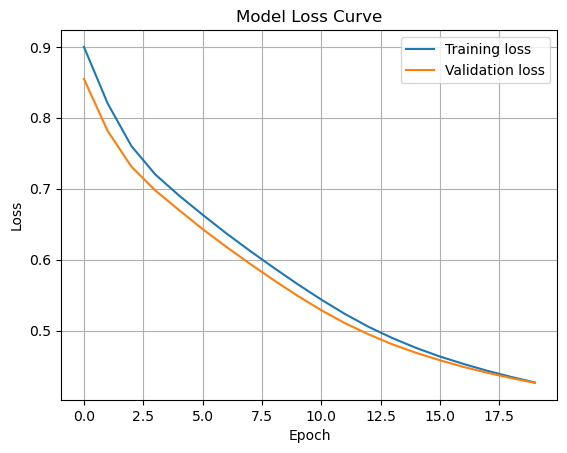

In [76]:
## Plotting the loss curve
history = model.fit(
    training_padded, training_labels,
    validation_data=(test_padded, testing_labels),
    epochs=20,
    batch_size=32
)

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

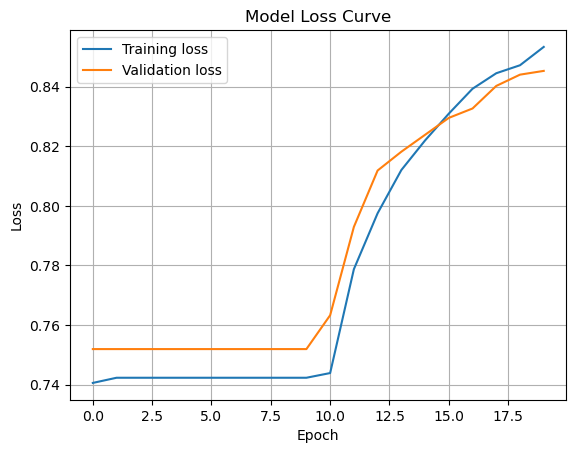

In [78]:
## Wow, it is so much better now, lets plot the accuracy curve

plt.plot(history.history['accuracy'], label='Training loss')
plt.plot(history.history['val_accuracy'], label='Validation loss')

plt.title('Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()